In [47]:
using Ipopt
using JuMP
using LinearAlgebra
using SparseArrays
using BenchmarkTools
using Random
using Distributions
using Plots
using FFTW

In [51]:
X = rand(10,10)
α = rand()

0.1509892971900123

In [58]:
Ahat = rand(10,10)
Fhat = rand(10,55)
Q = 1.0I(10)
;

In [74]:
n, m = size(X)
    
X2 = squareMatStates(X)

model = Model(Ipopt.Optimizer)
set_silent(model)
@variable(model, Pc[1:n, 1:n])
@expression(model, P, Pc*Pc' + α*I)
# @NLexpression(
#     model, 
#     PDEnorm, 
#     sum((X[:,i]'*P*Ahat*X[:,i] + X[:,i]'*P*Fhat*X2[:,i] - 0.25*X[:,i]'*Q*X[:,i]*X[:,i]'*P*X[:,i] + 0.5*X[:,i]'*Q*X[:,i])^2 for i in 1:m) 
# )  
@constraint(model, c, X*P*X' .<= 0.99999)
@NLobjective(model, Min, 
    sum((X[:,i]'*P*Ahat*X[:,i] + X[:,i]'*P*Fhat*X2[:,i] - 0.25*X[:,i]'*Q*X[:,i]*X[:,i]'*P*X[:,i] + 0.5*X[:,i]'*Q*X[:,i])^2 for i in 1:m) 
)
JuMP.optimize!(model)

ErrorException: Unexpected array [0.46791500152875254 0.7859693050579923 0.8758828913208587 0.9455695915462924 0.9037653627328008 0.8746117772447936 0.8392387146736442 0.2091335480268285 0.6951334743817806 0.27096052874620313] in nonlinear expression. Nonlinear expressions may contain only scalar expressions.

In [70]:
i = 1
X[:,i]'*P*Ahat*X[:,i] + X[:,i]'*P*Fhat*X2[:,i] - 0.25*X[:,i]'*Q*X[:,i]*X[:,i]'*P*X[:,i] + 0.5*X[:,i]'*Q*X[:,i]

492.12241819566395

In [43]:
function squareMatStates(Xmat)
    function vech_col(X)
        return vech(X * X')
    end
    tmp = vech_col.(eachcol(Xmat))
    return reduce(hcat, tmp)
end

"""
Half-vectorization operation

# Arguments
- `A`: matrix to half-vectorize

# Return
- `v`: half-vectorized form
"""
function vech(A::AbstractMatrix{T}) where {T}
    m = LinearAlgebra.checksquare(A)
    v = Vector{T}(undef, (m * (m + 1)) >> 1)
    k = 0
    for j = 1:m, i = j:m
        @inbounds v[k+=1] = A[i, j]
    end
    return v
end

vech

In [41]:
L = 1
N = 4
bar = -N/2:N/2-1
F = zeros(N, Int(N*(N+1)/2))
for k in bar
    foo = zeros(N, N)
    idx = Int(k + N/2 + 1)
    for m in bar
        # map from k to n
        p = Int(m + N/2 + 1)
        q = k - m
        # map from (k-m) to k
        if q < -N/2
            q += N
        elseif N/2 <= q 
            q -= N
        end
        # map from k to n
        q = Int(q + N/2 + 1)

        if q > p
            foo[q, p] += 1
        else 
            foo[p, q] += 1
        end
    end
    println("k = ", k)
    println("idx = ", idx)
    show(stdout, "text/plain", foo)
    println()
    F[idx, :] = -π * k / L * vech(foo)
end

k = -2.0
idx = 1
4×4 Matrix{Float64}:
 0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0
 2.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0


k = -1.0
idx = 2
4×4 Matrix{Float64}:
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  2.0  0.0  0.0
 2.0  0.0  0.0  0.0
k = 0.0
idx = 3
4×4 Matrix{Float64}:
 1.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0
 0.0  2.0  0.0  0.0
k = 1.0
idx = 4
4×4 Matrix{Float64}:
 0.0  0.0  0.0  0.0
 2.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  2.0  0.0


In [26]:
show(stdout, "text/plain", F)

6×21 Matrix{Float64}:
  0.0   0.0        0.0     18.8496   0.0      0.0       0.0      18.8496   0.0      0.0       0.0   0.0       0.0       0.0   0.0       0.0   0.0        0.0      0.0      18.8496   0.0
  0.0   0.0        0.0      0.0     12.5664   0.0       0.0       0.0     12.5664   0.0       0.0   6.28319   0.0       0.0   0.0       0.0   0.0        0.0      0.0       0.0      6.28319
  0.0   0.0        0.0      0.0      0.0      6.28319   0.0       0.0      0.0      6.28319   0.0   0.0       6.28319   0.0   0.0       0.0   0.0        0.0      0.0       0.0      0.0
 -0.0  -0.0       -0.0     -0.0     -0.0     -0.0      -0.0      -0.0     -0.0     -0.0      -0.0  -0.0      -0.0      -0.0  -0.0      -0.0  -0.0       -0.0     -0.0      -0.0     -0.0
 -0.0  -6.28319   -0.0     -0.0     -0.0     -0.0      -0.0      -0.0     -0.0     -0.0      -0.0  -0.0      -0.0      -0.0  -6.28319  -0.0  -6.28319   -0.0     -0.0      -0.0     -0.0
 -0.0  -0.0      -12.5664  -0.0     -0.0     -0.0

In [28]:
N = 6
u = sin.(2π * (0:N-1) / N)
uhat = fftshift(fft(u)) / N
ur = ifft(ifftshift(uhat)) * N

6-element Vector{ComplexF64}:
  6.162975822039155e-33 + 0.0im
     0.8660254037844386 + 0.0im
     0.8660254037844386 + 0.0im
 1.2246467991473532e-16 + 0.0im
    -0.8660254037844383 + 0.0im
    -0.8660254037844383 + 0.0im

In [29]:
u

6-element Vector{Float64}:
  0.0
  0.8660254037844386
  0.8660254037844387
  1.2246467991473532e-16
 -0.8660254037844385
 -0.8660254037844386

In [30]:
uhat

6-element Vector{ComplexF64}:
 -2.041077998578922e-17 + 0.0im
 1.9070629087032778e-18 + 0.0im
 -2.041077998578922e-17 + 0.49999999999999994im
   5.74182141399611e-17 + 0.0im
 -2.041077998578922e-17 - 0.49999999999999994im
 1.9070629087032778e-18 + 0.0im

In [18]:
N = 8
u = sin.(2π * (0:N-1) / N)
uhat = (fft(u)) / N
ur = ifft((uhat)) * N

8-element Vector{ComplexF64}:
  2.465190328815662e-32 + 0.0im
     0.7071067811865475 + 0.0im
     0.9999999999999999 + 0.0im
     0.7071067811865477 + 0.0im
 1.2246467991473532e-16 + 0.0im
    -0.7071067811865475 + 0.0im
    -0.9999999999999999 + 0.0im
    -0.7071067811865477 + 0.0im

In [38]:
uhat

6-element Vector{ComplexF64}:
 -2.041077998578922e-17 + 0.0im
 1.9070629087032778e-18 + 0.0im
 -2.041077998578922e-17 + 0.49999999999999994im
   5.74182141399611e-17 + 0.0im
 -2.041077998578922e-17 - 0.49999999999999994im
 1.9070629087032778e-18 + 0.0im

In [40]:
complex.(real.(uhat))

6-element Vector{ComplexF64}:
 -2.041077998578922e-17 + 0.0im
 1.9070629087032778e-18 + 0.0im
 -2.041077998578922e-17 + 0.0im
   5.74182141399611e-17 + 0.0im
 -2.041077998578922e-17 + 0.0im
 1.9070629087032778e-18 + 0.0im

In [35]:
show(stdout, "text/plain", uhat * uhat')

6×6 Matrix{ComplexF64}:
    4.166e-34+0.0im          -3.89246e-35+0.0im             4.166e-34+1.02054e-17im  -1.17195e-33+0.0im             4.166e-34-1.02054e-17im  -3.89246e-35+0.0im
 -3.89246e-35-0.0im           3.63689e-36+0.0im          -3.89246e-35-9.53531e-19im     1.095e-34+0.0im          -3.89246e-35+9.53531e-19im   3.63689e-36+0.0im
    4.166e-34-1.02054e-17im  -3.89246e-35+9.53531e-19im          0.25+0.0im          -1.17195e-33+2.87091e-17im         -0.25-2.04108e-17im  -3.89246e-35+9.53531e-19im
 -1.17195e-33-0.0im             1.095e-34+0.0im          -1.17195e-33-2.87091e-17im   3.29685e-33+0.0im          -1.17195e-33+2.87091e-17im     1.095e-34+0.0im
    4.166e-34+1.02054e-17im  -3.89246e-35-9.53531e-19im         -0.25+2.04108e-17im  -1.17195e-33-2.87091e-17im          0.25+0.0im          -3.89246e-35-9.53531e-19im
 -3.89246e-35-0.0im           3.63689e-36+0.0im          -3.89246e-35-9.53531e-19im     1.095e-34+0.0im          -3.89246e-35+9.53531e-19im   3.63689e-36+0.0im

In [33]:
show(stdout, "text/plain", kron(uhat, uhat))

36-element Vector{ComplexF64}:
  4.1659993962829375e-34 - 0.0im
  -3.892464144860184e-35 + 0.0im
  4.1659993962829375e-34 - 1.0205389992894608e-17im
 -1.1719505359876777e-33 + 0.0im
  4.1659993962829375e-34 + 1.0205389992894608e-17im
  -3.892464144860184e-35 + 0.0im
  -3.892464144860184e-35 + 0.0im
   3.636888937751806e-36 + 0.0im
  -3.892464144860184e-35 + 9.535314543516387e-19im
   1.095001464703019e-34 + 0.0im
  -3.892464144860184e-35 - 9.535314543516387e-19im
   3.636888937751806e-36 + 0.0im
  4.1659993962829375e-34 - 1.0205389992894608e-17im
  -3.892464144860184e-35 + 9.535314543516387e-19im
    -0.24999999999999994 - 2.0410779985789216e-17im
 -1.1719505359876777e-33 + 2.8709107069980546e-17im
     0.24999999999999994 + 0.0im
  -3.892464144860184e-35 + 9.535314543516387e-19im
 -1.1719505359876777e-33 + 0.0im
   1.095001464703019e-34 + 0.0im
 -1.1719505359876777e-33 + 2.8709107069980546e-17im
  3.2968513150224294e-33 + 0.0im
 -1.1719505359876777e-33 - 2.8709107069980546e-17im
   1.

In [34]:
show(stdout, "text/plain", vech(uhat * uhat'))

21-element Vector{ComplexF64}:
  4.1659993962829375e-34 + 0.0im
  -3.892464144860184e-35 - 0.0im
  4.1659993962829375e-34 - 1.0205389992894608e-17im
 -1.1719505359876777e-33 - 0.0im
  4.1659993962829375e-34 + 1.0205389992894608e-17im
  -3.892464144860184e-35 - 0.0im
   3.636888937751806e-36 + 0.0im
  -3.892464144860184e-35 + 9.535314543516387e-19im
   1.095001464703019e-34 + 0.0im
  -3.892464144860184e-35 - 9.535314543516387e-19im
   3.636888937751806e-36 + 0.0im
     0.24999999999999994 + 0.0im
 -1.1719505359876777e-33 - 2.8709107069980546e-17im
    -0.24999999999999994 + 2.0410779985789216e-17im
  -3.892464144860184e-35 - 9.535314543516387e-19im
  3.2968513150224294e-33 + 0.0im
 -1.1719505359876777e-33 - 2.8709107069980546e-17im
   1.095001464703019e-34 + 0.0im
     0.24999999999999994 + 0.0im
  -3.892464144860184e-35 + 9.535314543516387e-19im
   3.636888937751806e-36 + 0.0im

In [51]:

show(stdout, "text/plain", F)

4×10 Matrix{Float64}:
  0.0   0.0      12.5664   0.0       6.28319   0.0       0.0   0.0   0.0       6.28319
  0.0   0.0       0.0      6.28319   0.0       6.28319   0.0   0.0   0.0       0.0
 -0.0  -0.0      -0.0     -0.0      -0.0      -0.0      -0.0  -0.0  -0.0      -0.0
 -0.0  -6.28319  -0.0     -0.0      -0.0      -0.0      -0.0  -0.0  -6.28319  -0.0

In [45]:
show(stdout, "text/plain", F)

4×10 Matrix{Float64}:
 -0.0  -0.0      -0.0     -0.0      -0.0      -0.0      -0.0  -0.0  -0.0      -0.0
 -0.0  -6.28319  -0.0     -0.0      -0.0      -0.0      -0.0  -0.0  -6.28319  -0.0
  0.0   0.0      12.5664   0.0       6.28319   0.0       0.0   0.0   0.0       6.28319
  0.0   0.0       0.0      6.28319   0.0       6.28319   0.0   0.0   0.0       0.0

In [43]:
show(stdout, "text/plain", F)

4×10 Matrix{Float64}:
  0.0   0.0      12.5664   0.0       6.28319   0.0       0.0   0.0   0.0       6.28319
  0.0   0.0       0.0      6.28319   0.0       6.28319   0.0   0.0   0.0       0.0
 -0.0  -0.0      -0.0     -0.0      -0.0      -0.0      -0.0  -0.0  -0.0      -0.0
 -0.0  -6.28319  -0.0     -0.0      -0.0      -0.0      -0.0  -0.0  -6.28319  -0.0

In [104]:
ct1 = 0
ct2 = 0
for _ in 1:10000
    foo = rand(Uniform(-10,10), 4, 4)
    l1, _ = eigen(foo)
    l1 = real.(l1)
    l1_min = minimum(l1)
    l1_max = maximum(l1)

    bar = (foo + foo')/2
    l2, _ = eigen(bar)
    l2_min = minimum(l2)
    l2_max = maximum(l2)

    ct1 += Int(l1_min < l2_min)
    ct2 += Int(l2_max < l1_max)
end
println("ct1 = ", ct1)
println("ct2 = ", ct2)

ct1 = 0
ct2 = 0


In [105]:
foo = rand(Uniform(-10,10), 4, 4)
bar = (foo + foo')/2
pac = (foo - foo')/2

γ = 0.1
λp, v = eigen(bar)
# N_neg = count(i->(real(i) < 0.0), λp)
λp[real.(λp) .< 0] .= γ  # .+ (rand(N_neg) .* γ/10)
# N_img = count(i->(imag(i) != 0.0), λp)
# λp[imag.(λp) .!= 0.0] .= real.(λp[imag.(λp) .!= 0.0]) #+ rand(N_img) 
zap = v * Diagonal(λp) * (v\1.0I)

4×4 Matrix{Float64}:
  0.210726   -0.0982325  0.113304    0.111711
 -0.0982325   7.25141    0.0570213  -3.6207
  0.113304    0.0570213  0.219455    0.0357768
  0.111711   -3.6207     0.0357768   1.96825

In [14]:
a = [1 -1 0 -2]
b = any(a .< -3) + any(a .> 1) + any(a .> 0.1)

1

In [12]:
10^floor(log10(0.055)) / 2

0.005000000000000001

In [3]:
x = range(0,1,2^7)

0.0:0.007874015748031496:1.0

In [4]:
train_wave = (a,b,c) -> a .* sin.(2*π*ceil(b) .* x .+ c)

#11 (generic function with 1 method)

In [14]:
norm(train_wave(0.6,7,3))

4.781962917924284

In [5]:
if (@isdefined a) && (@isdefined b) && (@isdefined c)
    println("a and b are defined")
end

In [15]:
train_wave = (a,b,c) -> exp.(-a * cos.(π .* x .+ b).^2) .- c

#13 (generic function with 1 method)

In [45]:
train_wave3 = (a,b,c) -> exp.(-a * cos.(π .* x).^2 .+ b .* sin.(4*π .* x .+ π/3).^2 .- c .* cos.(3*π .* x).^2) 

#19 (generic function with 1 method)

In [74]:
norm(train_wave3(1,0.5,1))

7.1809556661202025

In [106]:
eigen(zap)

Eigen{Float64, Float64, Matrix{Float64}, Vector{Float64}}
values:
4-element Vector{Float64}:
 0.09999999999999949
 0.09999999999999963
 0.35584024650442625
 9.093994817808978
vectors:
4×4 Matrix{Float64}:
  0.758565   0.0937271  -0.651413  -0.0155071
 -0.11616    0.391881   -0.156486   0.891311
 -0.586409  -0.504641   -0.682957   0.00370225
 -0.259249   0.763532   -0.291107  -0.453113

In [107]:
eigen(bar)

Eigen{Float64, Float64, Matrix{Float64}, Vector{Float64}}
values:
4-element Vector{Float64}:
 -15.291019624856911
  -7.09950814662783
   0.35584024650442636
   9.093994817808985
vectors:
4×4 Matrix{Float64}:
  0.703379   0.28404   0.651413   0.0155071
 -0.260996   0.336093  0.156486  -0.891311
 -0.380669  -0.623416  0.682957  -0.00370225
 -0.540583   0.646309  0.291107   0.453113

In [10]:
s

4-element Vector{ComplexF64}:
               0.1 + 0.0im
               0.1 + 0.0im
 12.33193892302421 - 3.479711733044939im
 12.33193892302421 + 3.479711733044939im

In [15]:
v * diagm(s) * v^(-1)

4×4 Matrix{ComplexF64}:
  7.39597+4.0359e-16im   6.96738+2.62968e-15im  …   5.47594-7.06443e-16im
 -1.13444+2.30578e-16im  3.05888-1.18363e-15im     -3.99011+1.22111e-15im
  2.31802+4.66593e-16im  6.21741+3.06297e-16im     -1.36905+9.12678e-16im
  6.30664+1.25411e-16im  4.80703+2.06405e-15im      5.77726-8.21851e-16im

In [10]:
M = [0 0 0 -9;
    1 0 0 0;
    0 1 0 10;
    0 0 1 0]
s, v = eigen(M)

N = [0 0 0; 1 0 5; 0 1 0]
s, v = eigen(N)

f = (x) -> x.^4 -10 .* x.^2 .+ 9
for si in s
    val = f(si)
    println("f($si) = $val")
end

f(-2.23606797749979) = -16.000000000000004
f(0.0) = 9.0
f(2.23606797749979) = -16.000000000000004


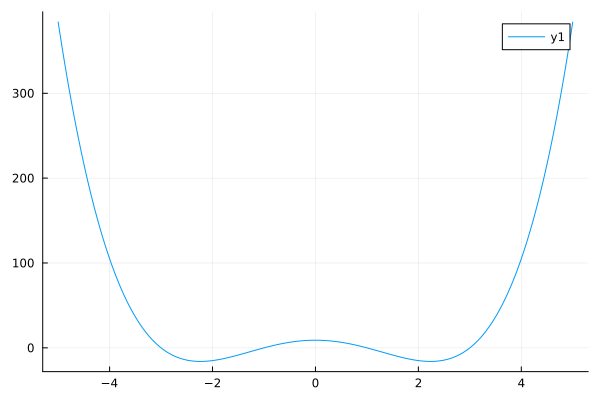

In [13]:
plot(-5:0.01:5, f(-5:0.01:5))

In [22]:
using JuMP
using Ipopt
using Pipe

i = 2
model = Model(Ipopt.Optimizer; add_bridges=false)
@variable(model, x[1:5])

@pipe x |> [JuMP.delete(model, x), JuMP.unregister(model, :x)]
@show JuMP.is_valid(model, x)

MethodError: MethodError: objects of type Vector{Nothing} are not callable
Use square brackets [] for indexing an Array.

In [2]:
struct elemat{T} <: AbstractVector{T}
    n::Int
    i::Int

    function elemat(n::Int, i::Int)
        @boundscheck n >= i || throw(ArgumentError("$i is larger than the size $n"))
        e = spzeros(n,1)
        e[i] = 1
        return e
    end
end

"""
    elemat(n,i,j)
"""

struct Elemat{T} <: AbstractMatrix{T}
    m :: Int
    n :: Int
    i :: Int
    j :: Int
    
    function Elemat(m::Integer, n::Integer, i::Integer, j::Integer)
        return elemat(m,i) * elemat(n,j)'
    end
end

Elemat(m::Integer, i::Integer, j::Integer) = Elemat(m, m, i, j)

Elemat

In [3]:
# Kronecker delta
function delta(i::Int, j::Int)
    return Int(i == j)
end

"""
    commat(n,i,j)
"""

struct commat{T} <: AbstractMatrix{T}
    m::Int
    n::Int

    function commat(m::Integer, n::Integer)
        v = [m * (j-1) + i for i in 1:m, j in 1:n]'[:]
        # apply this permutation to the rows (i.e. to each column) of identity matrix
        K = [[delta(i, j) for j in 1:(m*n)] for i in 1:(m*n)]
        tmp = [K[i] for i in v]
        return sparse(reduce(vcat, tmp'))
    end
end

commat(m::Integer) = commat(m, m)


"""
    nommat(n,i,j)
"""

struct nommat{T} <: AbstractMatrix{T}
    m::Int
    n::Int

    function nommat(m::Integer, n::Integer)
        mn = Int(m * n)
        return 0.5 * (sparse(1.0I, mn, mn) + commat(m, n))
    end
end

nommat(m::Integer) = nommat(m, m)

nommat

In [4]:
function vech(A::AbstractMatrix{T}) where {T}
    m = LinearAlgebra.checksquare(A)
    v = Vector{T}(undef, Int(m * (m + 1) /2))
    k = 0
    for j = 1:m, i = j:m
        @inbounds v[k+=1] = A[i, j]
    end
    return v
end

vech (generic function with 1 method)

In [5]:
struct unit_DL{T} <: AbstractVector{T}
    n::Int
    i::Int
    j::Int

    function unit_DL(n::Integer, i::Integer, j::Integer)
        @boundscheck i >= j || throw(ArgumentError("Does not satisfy i >= j"))
        u = spzeros(Int(0.5 * n * (n+1)), 1)
        u[Int( (j-1)*n + i - 0.5*j*(j-1) )] = 1.0
        return u
    end
end

In [6]:
struct elimat{T} <: AbstractMatrix{T}
    m::Int
    
    function elimat(m::Integer)
        T = tril(ones(m, m)) # Lower triangle of 1's
        f = findall(x -> x == 1, T[:]) # Get linear indexes of 1's
        k = m * (m + 1) / 2 # Row size of L
        m2 = m * m # Colunm size of L
        x = f + m2 * (0:k-1) # Linear indexes of the 1's within L'

        row = [mod(a, m2) != 0 ? mod(a, m2) : m2 for a in x]
        col = [mod(a, m2) != 0 ? div(a, m2) + 1 : div(a, m2) for a in x]
        L = sparse(row, col, ones(length(x)), m2, k)
        L = L' # Now transpose to actual L
        return L
    end
end

In [11]:
N = 3
Δx = 0.5
S = Int(N * (N + 1) / 2)
Fval = repeat([1.0, 1.0, -1.0, -1.0], outer=N - 2)

4-element Vector{Float64}:
  1.0
  1.0
 -1.0
 -1.0

In [12]:
row_i = repeat(2:(N-1), inner=4)

4-element Vector{Int64}:
 2
 2
 2
 2

In [14]:
N = 4
seq = Int.([2 + (N + 1) * (x - 1) - x * (x - 1) / 2 for x in 1:(N-1)])

3-element Vector{Int64}:
 2
 6
 9

In [ ]:
col_i = vcat(seq[1], repeat(seq[2:end-1], inner=2), seq[end])

In [ ]:
F = sparse(row_i, col_i, Fval, N, S) / 2 / Δx

In [54]:
N = 4
S = N*(N+1)/2
dx = 1/6

ii = repeat(2:(N-1), inner=4)
m = 2:N-1
mi = Int.([N*(N+1)/2 - (N-m)*(N-m+1)/2 - (N-m) for m in 2:N-1])               # this is where the xi^2 term is
mm = Int.([N*(N+1)/2 - (N-m).*(N-m+1)/2 - (N-m) - (N-(m-2)) for m in 2:N-1])  # this is where the x_{i-1}^2 term is
mp = Int.([N*(N+1)/2 - (N-m).*(N-m+1)/2 - (N-m) + (N-(m-1)) for m in 2:N-1])  # this is where the x_{i+1}^2 term is
jp = mi .+ 1  # this is the index of the x_{i+1}*x_i term
jm = mm .+ 1  # this is the index of the x_{i-1}*x_i term
jj = reshape([mp'; mm'; jp'; jm'],4*N-8);
vv = reshape([-ones(1,N-2); ones(1,N-2); -ones(1,N-2); ones(1,N-2)],4*N-8)/(6*dx);
F = sparse(ii,jj,vv,N,N*(N+1)/2)
# Boundary conditions
F[1,2] = -1/6/dx
F[1,N+1] = -1/6/dx
F[N,end-1] = 1/6/dx
F[N,end-2] = 1/6/dx
F

4×10 SparseMatrixCSC{Float64, Int64} with 12 stored entries:
  ⋅   -1.0   ⋅    ⋅   -1.0    ⋅    ⋅     ⋅     ⋅     ⋅ 
 1.0   1.0   ⋅    ⋅     ⋅   -1.0   ⋅   -1.0    ⋅     ⋅ 
  ⋅     ⋅    ⋅    ⋅    1.0   1.0   ⋅     ⋅   -1.0  -1.0
  ⋅     ⋅    ⋅    ⋅     ⋅     ⋅    ⋅    1.0   1.0    ⋅ 

In [64]:
a = range(0.8,1.2,10)

0.8:0.044444444444444446:1.2

In [67]:
zeros(1,1) .* rand(5,5)

5×5 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0

In [78]:
a  = zeros(1,1)
a[1] == 0
a = size(a)==(1,1) && a[1]==0 ? 0 : 1

0

In [86]:
typeof(NaN) == Float64

true

In [3]:
a = 1 
b = 2
c = 3 
n = 10
@info """

Constraint         = Non-Constrained
order              = $(n)
termination_status = $(a)
primal_status      = $(b)
objective_value    = $(c)
"""

┌ Info: 
│ Constraint        = Non-Constrained
│ order              = 10
│ termination_status = 1
│ primal_status      = 2
│ objective_value    = 3
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\scribble.ipynb:5


In [21]:
function generateEPmatrix(N, Δx, μ::Float64)
    # Create A matrix
    A = diagm(0 => (-2) * ones(N), 1 => ones(N - 1), -1 => ones(N - 1)) * μ / Δx^2
    A[1, N] = μ / Δx^2
    A[N, 1] = μ / Δx^2

    # Create F matrix
    S = Int(N * (N + 1) / 2)
    if N >= 3
        ii = repeat(2:(N-1), inner=4)
        m = 2:N-1
        mi = Int.([N*(N+1)/2 - (N-m)*(N-m+1)/2 - (N-m) for m in 2:N-1])               # this is where the xi^2 term is
        mm = Int.([N*(N+1)/2 - (N-m).*(N-m+1)/2 - (N-m) - (N-(m-2)) for m in 2:N-1])  # this is where the x_{i-1}^2 term is
        mp = Int.([N*(N+1)/2 - (N-m).*(N-m+1)/2 - (N-m) + (N-(m-1)) for m in 2:N-1])  # this is where the x_{i+1}^2 term is
        jp = mi .+ 1  # this is the index of the x_{i+1}*x_i term
        jm = mm .+ 1  # this is the index of the x_{i-1}*x_i term
        jj = reshape([mp'; mm'; jp'; jm'],4*N-8);
        vv = reshape([-ones(1,N-2); ones(1,N-2); -ones(1,N-2); ones(1,N-2)],4*N-8)/(6*Δx);
        F = sparse(ii,jj,vv,N,S)

        # Boundary conditions
        F[1,2] = -1/6/Δx
        F[1,N+1] = -1/6/Δx
        F[1,N] = 1/6/Δx
        F[1,end] = 1/6/Δx
        F[N,end-1] = 1/6/Δx
        F[N,end-2] = 1/6/Δx
        F[N,1] = -1/6/Δx
        F[N,N] = -1/6/Δx
    else
        F = zeros(N, S)
    end

    return A, F
end

generateEPmatrix (generic function with 1 method)

In [24]:
A, F = generateEPmatrix(4, 1/6, 1.0)

([-72.0 36.0 0.0 36.0; 36.0 -72.0 36.0 0.0; 0.0 36.0 -72.0 36.0; 36.0 0.0 36.0 -72.0], sparse([2, 4, 1, 2, 1, 4, 1, 3, 2, 3, 2, 4, 3, 4, 1, 3], [1, 1, 2, 2, 4, 4, 5, 5, 6, 6, 8, 8, 9, 9, 10, 10], [1.0, -1.0, -1.0, 1.0, 1.0, -1.0, -1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0, 1.0, 1.0, -1.0], 4, 10))

In [25]:
F

4×10 SparseMatrixCSC{Float64, Int64} with 16 stored entries:
   ⋅   -1.0   ⋅    1.0  -1.0    ⋅    ⋅     ⋅     ⋅    1.0
  1.0   1.0   ⋅     ⋅     ⋅   -1.0   ⋅   -1.0    ⋅     ⋅ 
   ⋅     ⋅    ⋅     ⋅    1.0   1.0   ⋅     ⋅   -1.0  -1.0
 -1.0    ⋅    ⋅   -1.0    ⋅     ⋅    ⋅    1.0   1.0    ⋅ 

In [3]:
A = rand(5,5)

5×5 Matrix{Float64}:
 0.417938  0.806233   0.699986   0.255434  0.83579
 0.336038  0.0927685  0.677172   0.562938  0.647408
 0.546276  0.873308   0.0371454  0.228456  0.0627147
 0.355165  0.495973   0.70881    0.164552  0.260624
 0.720333  0.897354   0.642968   0.771093  0.434109

In [7]:
a = 2
A + a.*I

5×5 Matrix{Float64}:
 2.41794   0.806233  0.699986  0.255434  0.83579
 0.336038  2.09277   0.677172  0.562938  0.647408
 0.546276  0.873308  2.03715   0.228456  0.0627147
 0.355165  0.495973  0.70881   2.16455   0.260624
 0.720333  0.897354  0.642968  0.771093  2.43411

In [74]:
pd = 1
qd = 2
rd = 3
A = 3
C = 1
Id = 1
po = 2
qo = qd/pd * po
ro = 2*Id*rd*po/(Id*pd+(A-C)*po)


X12 = ((A-C)*ro - 2*Id*rd) / A
X13 = ((A-C)*qo + Id*qd) / A
X21 = (2*Id*rd - (A-C)*ro) / A
X23 = (-(A-C)*po + Id*pd) / A
X31 = -Id*qd / C
X32 = Id*pd / C


X = [0 X12 X13;
    X21 0 X23;
    X31 X32 0]

3×3 Matrix{Float64}:
  0.0  -0.4   3.33333
  0.4   0.0  -1.0
 -2.0   1.0   0.0

In [75]:
eigen(X)

Eigen{ComplexF64, ComplexF64, Matrix{ComplexF64}, Vector{ComplexF64}}
values:
3-element Vector{ComplexF64}:
 -0.03405137184316559 - 2.7982396527888516im
 -0.03405137184316559 + 2.7982396527888516im
   0.0681027436863315 + 0.0im
vectors:
3×3 Matrix{ComplexF64}:
   0.748027-0.0im         0.748027+0.0im       0.441047+0.0im
  -0.220832+0.116442im   -0.220832-0.116442im  0.889981+0.0im
 -0.0341412-0.613975im  -0.0341412+0.613975im  0.115809+0.0im

## Positive Definite matrix

In [1]:
using LinearAlgebra
using JuMP
using Random
using SCS
using BenchmarkTools

In [4]:
function model(A, n)
    model1 = Model(SCS.Optimizer)
    set_silent(model1)
    @variable(model1, D[1:n, 1:n], PSD)
    @expression(model1, d, diag(D))
    @objective(model1, Min, sum(d))
    @constraint(model1, (A + D) in PSDCone())
    JuMP.optimize!(model1)
    Dopt = value.(D)
    return Dopt
end

N = 10
λ_all = Vector{Vector{Float64}}(undef, N)
λpsd_all = Vector{Vector{Float64}}(undef, N)
λpd_all = Vector{Vector{Float64}}(undef, N)
Dopt_all = Vector{Matrix{Float64}}(undef, N)
Apd_all = Vector{Matrix{Float64}}(undef, N)

for n in 1:N

    A = rand(n,n)
    A = (A + A')/2

    # Dopt = model(A, n)
    not_pd = true
    γ_lb = 1e-8
    while not_pd
        model1 = Model(SCS.Optimizer)
        set_silent(model1)
        @variable(model1, D[1:n, 1:n], PSD)
        @variable(model1, γ_lb <= γ <= 0.1)
        @expression(model1, d, diag(D))
        @objective(model1, Min, sum(d) + γ)
        @constraint(model1, (A + D) in PSDCone())
        @constraint(model1, (A + D .+ γ*I) .>= γ_lb/10)
        JuMP.optimize!(model1)
        Dopt = value.(D)
        γopt = value(γ)

        Apd = A + Dopt + γopt * I
        not_pd = !isposdef(Apd)
        γ_lb *= 10
        if γ_lb > 1
            break
        end
        if !not_pd
            println("n = ", n)
            println("γ_lb = ", γ_lb)
            Apd_all[n] = Apd
            Dopt_all[n] = Dopt
            λpd, _ = eigen(Apd)
            λpd_all[n] = λpd
        end
    end

    # JuMP.unregister(model1, :D)
    # JuMP.unregister(model1, :d)
    # JuMP.unregister(model1, :γ)

end

n = 1
γ_lb = 1.0e-7
n = 2
γ_lb = 1.0e-7
n = 3
γ_lb = 0.001
n = 4
γ_lb = 1.0e-7
n = 5
γ_lb = 0.001
n = 6
γ_lb = 9.999999999999999e-5


n = 7
γ_lb = 1.0e-7


n = 8
γ_lb = 9.999999999999999e-5


n = 9
γ_lb = 9.999999999999999e-5


n = 10
γ_lb = 9.999999999999999e-6


In [59]:
γopt

9.98139725321573e-5

In [60]:
Dopt_all[10]

10×10 Matrix{Float64}:
  0.109782    0.0369402  -0.0899058  …  -0.0130133  -0.019333   -0.0109649
  0.0369402   0.30425    -0.242847       0.0952652   0.152305    0.0730081
 -0.0899058  -0.242847    0.241223      -0.0496197  -0.0844962  -0.104144
  0.0565693  -0.156551    0.0961764      0.0467147  -0.201088   -0.174342
  0.0614738   0.156457   -0.107812       0.118548    0.0682734  -0.179571
 -0.118998   -0.0452032   0.0837047  …   0.225019   -0.26491    -0.0422486
 -0.0199376  -0.326182    0.225377      -0.324206    0.0229013   0.136166
 -0.0130133   0.0952652  -0.0496197      0.276421   -0.189697   -0.159147
 -0.019333    0.152305   -0.0844962     -0.189697    0.406185    0.124124
 -0.0109649   0.0730081  -0.104144      -0.159147    0.124124    0.354157

In [5]:
for n in 1:N
    println("n = $n")
    println("λpd = ", λpd_all[n])
end

n = 1


λpd = 

[0.4734009490807311]
n = 2
λpd = [0.1849819833372284, 0.8820680560833327]
n = 3
λpd = [6.468577374406588e-5, 0.05566982780519548, 1.6117583650113532]
n = 4
λpd = [4.661279514244788e-5, 4.920875335063208e-5, 0.27870774945815124, 2.0049585300588713]
n = 5
λpd = [8.466359665425808e-5, 9.947412203149814e-5, 0.29784402185480136, 0.4639974525485556, 2.4125151784209677]
n = 6
λpd = [3.706122762959494e-6, 4.215574237891904e-6, 3.4193134752292945e-5, 0.737339150089506, 0.944097413701972, 2.8864282835122443]
n = 7
λpd = [9.811585948430339e-9, 9.863204921078684e-9, 9.883203783152058e-9, 1.0190787550512542e-8, 0.2023844666022052, 0.5126137609699556, 3.642776704069516]
n = 8
λpd = [0.0001353556312818269, 0.00013543256623279603, 0.00013547547725489587, 0.00013581635415185972, 0.4583539083708855, 0.6124596329307473, 0.7647150868774771, 4.071633237787463]
n = 9
λpd = [4.3061835188726397e-7, 1.1744208572273822e-5, 1.759295132737878e-5, 2.3475304593142915e-5, 0.0557134707476078, 0.36737622094088573, 0.5

In [1]:
a = 1
b = 2
@assert a==b "a is not equal to b"

AssertionError: AssertionError: a is not equal to b

## FFT Scribbles

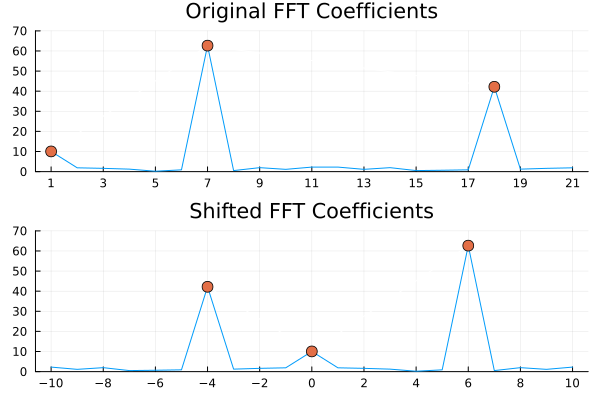

In [1]:
using FFTW
using Plots

N = 21
xj = (0:N-1)*2*π/N
f = 2*exp.(17*im*xj) + 3*exp.(6*im*xj) + rand(N)

original_k = 1:N
shifted_k = fftshift(fftfreq(N)*N)

original_fft = fft(f)
shifted_fft = fftshift(fft(f))

p1 = plot(original_k,abs.(original_fft),title="Original FFT Coefficients", xticks=original_k[1:2:end], legend=false, ylims=(0,70));
p1 = plot!([1,7,18],abs.(original_fft[[1,7,18]]),markershape=:circle,markersize=6,linecolor="white");
p2 = plot(shifted_k,abs.(shifted_fft),title="Shifted FFT Coefficients",xticks=shifted_k[1:2:end], legend=false, ylims=(0,70));
p2 = plot!([-4,0,6],abs.(shifted_fft[[7,11,17]]),markershape=:circle,markersize=6,linecolor="white");
plot(p1,p2,layout=(2,1))

In [72]:
using FFTW
using Test

N = 22
xj = (0:N-1)*2*π/N
f = 2*sin.(6*xj) + 0.1*rand(N)
z = zeros(ComplexF64, 12)

p = plan_rfft(f)
ip = plan_irfft(z,N)

Y = p * f
f2 = ip * Y

@test f ≈ f2
# Test Passed

Test Passed

In [73]:
length(f)

22

In [74]:
length(f2)

22

In [75]:
length(Y)

12

In [2]:
N = 128
k = collect(-N/2:1.0:N/2-1)

128-element Vector{Float64}:
 -64.0
 -63.0
 -62.0
 -61.0
 -60.0
 -59.0
 -58.0
 -57.0
 -56.0
 -55.0
   ⋮
  55.0
  56.0
  57.0
  58.0
  59.0
  60.0
  61.0
  62.0
  63.0

In [3]:
k = 1
u = zeros(10, 55)
for m in 1:10
    
end


MethodError: MethodError: no method matching similar(::Int64)
Closest candidates are:
  similar(!Matched::Union{LinearAlgebra.Adjoint{T, var"#s886"}, LinearAlgebra.Transpose{T, var"#s886"}} where {T, var"#s886"<:(AbstractVector)}) at C:\Users\tkoike3\AppData\Local\Programs\Julia-1.8.5\share\julia\stdlib\v1.8\LinearAlgebra\src\adjtrans.jl:206
  similar(!Matched::Union{LinearAlgebra.Adjoint{T, var"#s886"}, LinearAlgebra.Transpose{T, var"#s886"}} where {T, var"#s886"<:(AbstractVector)}, !Matched::Type{T}) where T at C:\Users\tkoike3\AppData\Local\Programs\Julia-1.8.5\share\julia\stdlib\v1.8\LinearAlgebra\src\adjtrans.jl:207
  similar(!Matched::Union{LinearAlgebra.Adjoint{T, S}, LinearAlgebra.Transpose{T, S}} where {T, S}) at C:\Users\tkoike3\AppData\Local\Programs\Julia-1.8.5\share\julia\stdlib\v1.8\LinearAlgebra\src\adjtrans.jl:210
  ...